Đã lưu biểu đồ kiểm chứng tại: vad_check.png


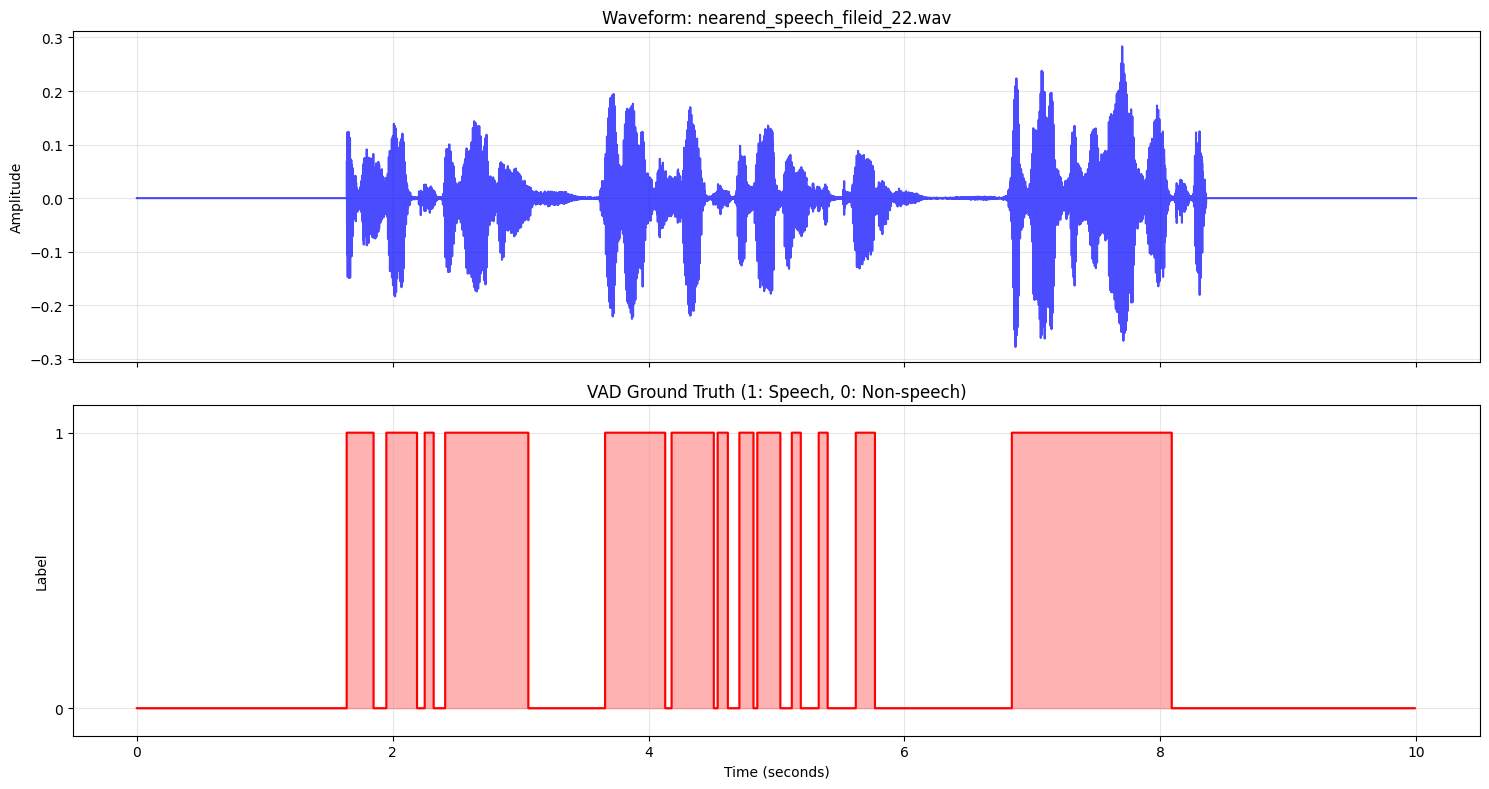

In [3]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os

def visualize_vad_alignment(wav_path, npy_path, output_fig="vad_check.png"):
    """
    Vẽ biểu đồ kiểm chứng sự khớp nối giữa Audio và Nhãn VAD.
    
    Args:
        wav_path (str): Đường dẫn file .wav clean.
        npy_path (str): Đường dẫn file .npy VAD tương ứng.
        output_fig (str): Tên file ảnh đầu ra.
    """
    # 1. Load âm thanh (Sử dụng 16kHz như lúc sinh nhãn)
    y, sr = librosa.load(wav_path, sr=16000)
    duration = len(y) / sr
    
    # 2. Load nhãn VAD
    vad_labels = np.load(npy_path)
    
    # 3. Tạo trục thời gian
    # Trục thời gian cho waveform
    times_wav = np.linspace(0, duration, len(y))
    
    # Trục thời gian cho VAD (mỗi nhãn là 10ms = 0.01s)
    # Cần tạo mảng thời gian tương ứng với tâm của mỗi khung 10ms
    times_vad = np.arange(len(vad_labels)) * 0.01
    
    # 4. Vẽ đồ thị
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    
    # Subplot 1: Waveform
    ax1.plot(times_wav, y, color='blue', alpha=0.7)
    ax1.set_title(f"Waveform: {os.path.basename(wav_path)}")
    ax1.set_ylabel("Amplitude")
    ax1.grid(True, alpha=0.3)
    
    # Subplot 2: VAD Labels
    # Vẽ dạng step (bậc thang) để thấy rõ vùng 0 và 1
    ax2.step(times_vad, vad_labels, where='post', color='red', linewidth=1.5)
    ax2.fill_between(times_vad, vad_labels, step="post", alpha=0.3, color='red')
    ax2.set_title("VAD Ground Truth (1: Speech, 0: Non-speech)")
    ax2.set_xlabel("Time (seconds)")
    ax2.set_ylabel("Label")
    ax2.set_ylim(-0.1, 1.1)
    ax2.set_yticks([0, 1])
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_fig)
    print(f"Đã lưu biểu đồ kiểm chứng tại: {output_fig}")
    plt.show()

if __name__ == "__main__":
    # Bạn chỉ cần thay đường dẫn một file bất kỳ để kiểm tra
    SAMPLE_ID = "nearend_speech_fileid_22" # Thay bằng ID file của bạn
    WAV_FILE = f"D:/AEC-Challenge/datasets/synthetic/nearend_speech/{SAMPLE_ID}.wav"
    NPY_FILE = f"D:/AEC-Challenge/datasets/synthetic/vad/{SAMPLE_ID}.npy"
    
    if os.path.exists(WAV_FILE) and os.path.exists(NPY_FILE):
        visualize_vad_alignment(WAV_FILE, NPY_FILE)
    else:
        print("Không tìm thấy file audio hoặc file nhãn tương ứng. Hãy kiểm tra lại đường dẫn!")

In [1]:
import os
import numpy as np
import librosa
import webrtcvad
from tqdm import tqdm

def generate_vad_labels_no_torch(clean_dir, vad_out_dir, aggressiveness=3):
    """
    Sinh nhãn VAD từ thư mục clean speech không sử dụng torch/torchaudio.
    
    Args:
        clean_dir (str): Thư mục chứa file .wav sạch.
        vad_out_dir (str): Thư mục để lưu file nhãn .npy.
        aggressiveness (int): Độ nhạy của VAD (0-3).
    """
    # Khởi tạo WebRTC VAD
    vad = webrtcvad.Vad(aggressiveness)
    
    if not os.path.exists(vad_out_dir):
        os.makedirs(vad_out_dir)
    
    # Lấy danh sách file wav
    files = [f for f in os.listdir(clean_dir) if f.endswith('.wav')]
    print(f"Sử dụng Librosa & WebRTC-VAD để xử lý {len(files)} file...")

    for filename in tqdm(files):
        file_path = os.path.join(clean_dir, filename)
        
        try:
            # 1. Load Audio bằng librosa (tự động resample về 16kHz và chuyển mono)
            # WebRTC-VAD yêu cầu sample rate 8k, 16k, 32k hoặc 48k
            y, sr = librosa.load(file_path, sr=16000, mono=True)
            
            # 2. Chuyển đổi sang PCM 16-bit
            # Librosa load audio ở dạng float [-1, 1], cần chuyển về int16 cho WebRTC-VAD
            y_int16 = (y * 32767).astype(np.int16)
            
            # 3. Định nghĩa kích thước khung 10ms (hop size chuẩn)
            # 16000 * 0.01 = 160 mẫu
            frame_len = int(sr * 0.01) 
            
            vad_labels = []
            
            # 4. Quét qua mảng audio theo từng khung 160 mẫu
            for i in range(0, len(y_int16), frame_len):
                frame = y_int16[i : i + frame_len]
                
                # Xử lý đoạn cuối nếu không đủ frame_len
                if len(frame) < frame_len:
                    frame = np.pad(frame, (0, frame_len - len(frame)))
                
                # Kiểm tra tiếng nói
                is_speech = vad.is_speech(frame.tobytes(), sr)
                vad_labels.append(1 if is_speech else 0)
            
            # 5. Lưu nhãn Ground Truth P_bar
            # Nhãn này sẽ là vector T x 1 phục vụ loss đa nhiệm
            vad_array = np.array(vad_labels, dtype=np.int8)
            save_name = os.path.splitext(filename)[0] + ".npy"
            np.save(os.path.join(vad_out_dir, save_name), vad_array)
            
        except Exception as e:
            print(f"Lỗi khi xử lý file {filename}: {e}")

if __name__ == "__main__":
    # Cấu hình đường dẫn của bạn
    CLEAN_INPUT = "D:/AEC-Challenge/datasets/material/clean"
    VAD_OUTPUT = "D:/AEC-Challenge/datasets/material/vad"
    
    
    generate_vad_labels_no_torch(CLEAN_INPUT, VAD_OUTPUT, aggressiveness=3)
    print("\nNuguri đã hoàn thành việc sinh nhãn Ground Truth VAD!")




d:\Neural-AEC\.venv\Lib\site-packages\webrtcvad.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Sử dụng Librosa & WebRTC-VAD để xử lý 7991 file...


100%|██████████| 7991/7991 [01:16<00:00, 104.31it/s]


Nuguri đã hoàn thành việc sinh nhãn Ground Truth VAD!
